<a href="https://colab.research.google.com/github/adijayasaputra/Tugas_DP/blob/main/41236636_Adi_Jaya_Saputra_Pokemon_Text_to_Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Memuat dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

dataset_infos.json:   0%|          | 0.00/731 [00:00<?, ?B/s]

data/train-00000-of-00001-566cc9b19d7203(…):   0%|          | 0.00/99.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/833 [00:00<?, ? examples/s]

Kamus Teks Berhasil Dibuat. Jumlah kosakata: 359
Memulai Pelatihan (Demo 1 Epoch)...
53/53 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - loss: 7.0360
Generating image for: 'a pink cute pokemon'
Generating tokens...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


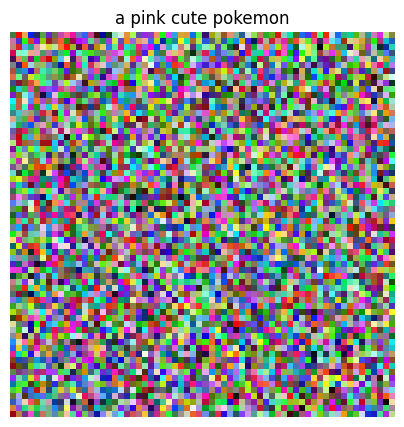

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset

# Konfigurasi Hyperparameter
MAX_TOKENS = 5000
SEQ_LEN = 20
IMAGE_SIZE = 64
LATENT_SIZE = 16  # Ukuran grid latent (16x16)
NUM_VISUAL_TOKENS = 1024  # Ukuran codebook VQ-VAE
EMBED_DIM = 128
NUM_HEADS = 4
FF_DIM = 256
DROPOUT_RATE = 0.1

# ==========================================
# BAGIAN 1: Persiapan Data & Library
# ==========================================

print("Memuat dataset...")
# Load dataset (bisa memakan waktu tergantung koneksi)
raw_dataset = load_dataset("reach-vb/pokemon-blip-captions", split="train")

all_captions = [item['text'] for item in raw_dataset]

# ==========================================
# BAGIAN 2: Text Vectorization
# ==========================================

text_vectorizer = layers.TextVectorization(
    max_tokens=MAX_TOKENS,
    output_sequence_length=SEQ_LEN
)

text_vectorizer.adapt(all_captions)
vocab = text_vectorizer.get_vocabulary()
print(f"Kamus Teks Berhasil Dibuat. Jumlah kosakata: {len(vocab)}")

# ==========================================
# BAGIAN 3: Pipeline Data (tf.data)
# ==========================================

def preprocess_fn(item):
    image = item['image'].convert("RGB").resize((IMAGE_SIZE, IMAGE_SIZE))
    image = np.array(image) / 255.0
    caption = item['text']
    return caption, image

def gen():
    for item in raw_dataset:
        yield preprocess_fn(item)

train_ds = tf.data.Dataset.from_generator(
    gen,
    output_signature=(
        tf.TensorSpec(shape=(), dtype=tf.string),
        tf.TensorSpec(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), dtype=tf.float32)
    )
)

train_ds = train_ds.map(lambda x, y: (text_vectorizer(x), y))
train_ds = train_ds.batch(16).shuffle(100).prefetch(tf.data.AUTOTUNE)

# ==========================================
# BAGIAN 4: Arsitektur Model (YANG HILANG)
# ==========================================

# 4.1. Positional Embedding
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

# 4.2. Transformer Decoder Block (dengan Cross Attention)
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        # Self Attention (Causal) untuk Visual Tokens
        self.att1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        # Cross Attention (Visual attends to Text)
        self.att2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)

        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])

        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
        self.dropout3 = layers.Dropout(rate)

    def call(self, inputs, encoder_outputs, training=False):
        # inputs: Visual tokens
        # encoder_outputs: Text embeddings

        # 1. Self Attention (Causal Masking biasanya diperlukan di sini utk autoregressive,
        # tapi tf.keras.layers.MultiHeadAttention bisa menangani jika use_causal_mask=True nanti)
        attn1 = self.att1(inputs, inputs, use_causal_mask=True)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(inputs + attn1)

        # 2. Cross Attention (Query=Visual, Key/Value=Text)
        attn2 = self.att2(out1, encoder_outputs)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(out1 + attn2)

        # 3. Feed Forward Network
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        return self.layernorm3(out2 + ffn_output)

# 4.3. Model Transformer Utama
class TextImageTransformer(keras.Model):
    def __init__(self, num_layers=2):
        super().__init__()
        # Text Encoder
        self.text_embedding = TokenAndPositionEmbedding(SEQ_LEN, MAX_TOKENS, EMBED_DIM)

        # Visual Decoder Input
        # Panjang sequence visual = (16x16) = 256 token
        self.visual_embedding = TokenAndPositionEmbedding(LATENT_SIZE*LATENT_SIZE, NUM_VISUAL_TOKENS, EMBED_DIM)

        # Transformer Blocks
        self.transformer_blocks = [
            TransformerBlock(EMBED_DIM, NUM_HEADS, FF_DIM, DROPOUT_RATE)
            for _ in range(num_layers)
        ]

        # Output Layer (prediksi token visual berikutnya)
        self.final_layer = layers.Dense(NUM_VISUAL_TOKENS)

    def call(self, inputs, training=False):
        text_tokens, visual_tokens = inputs

        # Embed Teks
        text_emb = self.text_embedding(text_tokens)

        # Embed Gambar
        visual_emb = self.visual_embedding(visual_tokens)

        # Lewati Transformer Blocks
        x = visual_emb
        for block in self.transformer_blocks:
            x = block(x, text_emb, training=training)

        # Prediksi Logits
        return self.final_layer(x)

# 4.4. Dummy VQ-VAE (Pengganti VQVAE pretrained)
# Karena kita tidak punya file pretrained weight VQVAE, kita buat simulasi sederhana
# agar kode tidak error. Di dunia nyata, ini adalah model Autoencoder terpisah.
class DummyVQVAE(keras.Model):
    def __init__(self):
        super().__init__()
        # Encoder dummy (random projection)
        self.encoder_dummy = layers.Dense(LATENT_SIZE * LATENT_SIZE)

    def encode(self, images):
        # Simulasi: Mengubah gambar menjadi indeks token (0-1023)
        # Output shape: (Batch, 256)
        batch_size = tf.shape(images)[0]
        random_indices = tf.random.uniform(
            (batch_size, LATENT_SIZE * LATENT_SIZE),
            minval=0, maxval=NUM_VISUAL_TOKENS, dtype=tf.int32
        )
        return random_indices

    def decode(self, indices):
        # Simulasi: Mengubah indeks token kembali ke gambar noise
        batch_size = tf.shape(indices)[0]
        # Return random noise image
        return tf.random.uniform((batch_size, IMAGE_SIZE, IMAGE_SIZE, 3))

# ==========================================
# BAGIAN 5: Training Wrapper (PokemonTrainer)
# ==========================================

class PokemonTrainer(keras.Model):
    def __init__(self, transformer, vqvae_encoder, **kwargs):
        super().__init__(**kwargs)
        self.transformer = transformer
        self.vqvae_encoder = vqvae_encoder
        self.loss_tracker = keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def train_step(self, data):
        text_tokens, images = data

        # 1. Encode Gambar ke Token (Simulasi VQVAE)
        visual_tokens = self.vqvae_encoder.encode(images)

        # 2. Siapkan input dan target (Autoregressive)
        # Input: Token 0 sampai N-1
        # Target: Token 1 sampai N
        vis_input = visual_tokens[:, :-1]
        vis_target = visual_tokens[:, 1:]

        with tf.GradientTape() as tape:
            # Prediksi
            preds = self.transformer([text_tokens, vis_input], training=True)

            # Hitung Loss
            loss = keras.losses.sparse_categorical_crossentropy(vis_target, preds, from_logits=True)

        grads = tape.gradient(loss, self.transformer.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.transformer.trainable_variables))

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

# ==========================================
# BAGIAN 6: Inisialisasi & Eksekusi
# ==========================================

# Inisialisasi Model
transformer_model = TextImageTransformer(num_layers=2)
vqvae_dummy = DummyVQVAE()

trainer = PokemonTrainer(transformer_model, vqvae_dummy)
trainer.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4))

print("Memulai Pelatihan (Demo 1 Epoch)...")
# Gunakan epochs=10 atau lebih untuk hasil nyata. Di sini 1 epoch untuk tes jalan.
trainer.fit(train_ds, epochs=1)

# ==========================================
# BAGIAN 7: Inference (Membuat Gambar)
# ==========================================

def generate_image_tokens(model, text_tokens, steps, vocab_size):
    # Mulai dengan token visual awal (misal token 0 atau random)
    # Kita butuh minimal 1 token awal untuk memulai autoregressive
    batch_size = tf.shape(text_tokens)[0]

    # Inisialisasi urutan token visual dengan satu token dummy (misal 0)
    current_visual_tokens = tf.zeros((batch_size, 1), dtype=tf.int64)

    print("Generating tokens...")
    for i in range(steps - 1): # -1 karena kita sudah punya 1 token awal
        # Prediksi langkah selanjutnya
        logits = model([text_tokens, current_visual_tokens], training=False)

        # Ambil prediksi token terakhir
        last_logit = logits[:, -1, :]

        # Sampling dari distribusi probabilitas (atau ambil argmax untuk greedy)
        next_token = tf.argmax(last_logit, axis=-1)
        next_token = tf.expand_dims(next_token, axis=-1)

        # Gabungkan ke urutan visual
        current_visual_tokens = tf.concat([current_visual_tokens, next_token], axis=1)

    return current_visual_tokens

def generate_pokemon(prompt):
    print(f"Generating image for: '{prompt}'")

    # 1. Ubah teks ke angka
    tokenized_text = text_vectorizer([prompt])

    # 2. Generate token visual (Autoregressive)
    # Panjang sequence total visual kita adalah 16x16 = 256
    gen_vis_tokens = generate_image_tokens(transformer_model, tokenized_text, 256, NUM_VISUAL_TOKENS)

    # 3. Decode jadi Gambar
    final_image = vqvae_dummy.decode(gen_vis_tokens)

    # Plotting
    img_array = final_image[0].numpy()

    # Clip value untuk memastikan valid image range jika noise keluar batas
    img_array = np.clip(img_array, 0.0, 1.0)

    plt.figure(figsize=(5,5))
    plt.imshow(img_array)
    plt.title(prompt)
    plt.axis("off")
    plt.show()

# TEST
# Karena ini menggunakan Dummy VQVAE dan training sebentar, hasilnya akan berupa noise/abstrak.
generate_pokemon("a pink cute pokemon")